In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import ExtraTreesClassifier

In [3]:
df= pd.read_csv("C:\\Users\\ASUS\\Documents\\Data Analysis\\AB_NYC_2019.csv")

# Information about each variable within the dataset:


# Id: Listing ID Number
# Name: Name of the listing
# host_id: Customer’s Id
# host_name: Customer’s Name 
# neighbourhood_group: location
# neighbourhood: area
# latitude: latitude coordinates
# longitude: longitude coordinates
# room_type: listing room types/space types 
# price : price in dollars
# minimum_nights: number of nights spent by the customer
# number_of_reviews: total number of reviews given by the customer
# last_review : shows the date when the review was last submitted by the customer
# reviews_per_month: Percentage of reviews given per month
# calculated_host_listings_count: number of bookings done by the customer
# availability_365: shows information about geographic availability of the listings/rented apartments/villas.

In [4]:
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [5]:
# Our next step is to find out whether the data contains any missing values:
df.isnull().sum()
# the below table shows us that there are some missing values under name, host_name, last_review and reviews_per_month columns.
# Hence, those missing values needs to be treated and the data needs to be cleaned here after.
# As such we are going to drop the name, host_name and last_review going forward, 
# so we will only concentrate on having the na/missing values treated for reviews_per_month column
# as reviews_per_month is a numerical variable.

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

# Starting with Data Cleaning :

In [6]:
# Treating the missing values within the dataset:
mean = df['reviews_per_month'].mean()
df['reviews_per_month'].fillna(mean, inplace= True)
# Last review cannot be treated in the same way as the data contains a date which needs to be treated seperately,
# however the last review will get deleted from our analysis as we are trying to predict the price variable anyway.
# As reviews_per_month is a float variable, we need to have it converted to integers:
df['reviews_per_month'] = df['reviews_per_month'].astype(int)

Data Conversion:

In [7]:
# We now need to define the features we are interested to proceed with our analysis:
df2 = df.drop(['id','name','host_id','host_name','last_review'], axis=1)
df2.isnull().sum()
# Voila! We got rid of the na values.
# Here, we can observe that the maximum price goes to 10,000 dollars, and average being 142 dollars and 33 cents.
# We are going to plot the visualization graphs to check if these features show normal distribution curve since the given below features 
# are showing positive relationship with the target variable, price.
# 1.) price and availability_365,
# 2.) price and minimum_nights,
# 3.) price and Calculated_host_listings_count, etc.
# We will also check for multi-collinearity (or if the selected features do influence/affect each other in any way possible).

neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
dtype: int64

In [8]:
df2.room_type.unique()

array(['Private room', 'Entire home/apt', 'Shared room'], dtype=object)

In [9]:
# Similarily, we converted the room_type into numerical variables as well:
def room_type(x):
    if x == 'Private room':
        return 1
    if x == 'Entire home/apt':
        return 2
    if x == 'Shared room':
        return 3 
    
df2['room_type'] = df2['room_type'].apply(room_type)

In [10]:
def neighbourhood_group(x):
    if x == 'Brooklyn':
        return 1
    if x == 'Manhattan':
        return 2
    if x == 'Queens':
        return 3
    if x == 'Staten Island':
        return 4
    if x == 'Bronx':
        return 5

df2['neighbourhood_group'] = df2['neighbourhood_group'].apply(neighbourhood_group)
df2['neighbourhood_group'].unique()

array([1, 2, 3, 4, 5], dtype=int64)

In [11]:
# Before examining the price feature, categorical variables will be mapped with the help of cat.codes.
# It is also known to be the easiest technique to have the data points converted into integers:
df2['neighbourhood'] = df2['neighbourhood'].astype("category").cat.codes
# The main idea of using a cat.codes for conversion is to 
# have different types of categories segregate into seperate numbers by grouping each category under the same number.

# Correlation & Heatmaps:
# Correlation is used for measuring the strength and direction of the linear relationship between target and regressor variables.
# It is a statistical measure that indicates the extent to which two variables chnage together.
# A positive correlation means the variables increase or decrease together.
# A negative correlation means if one variable increases, the other decreases.
# The correlation lies between -1.0 and 1.0.
# -1.0 indicates a perfect negative correlation, whereas 1.0 indicqates perfect positive correlation.

Text(0.5, 1.0, 'Correlation Matrix')

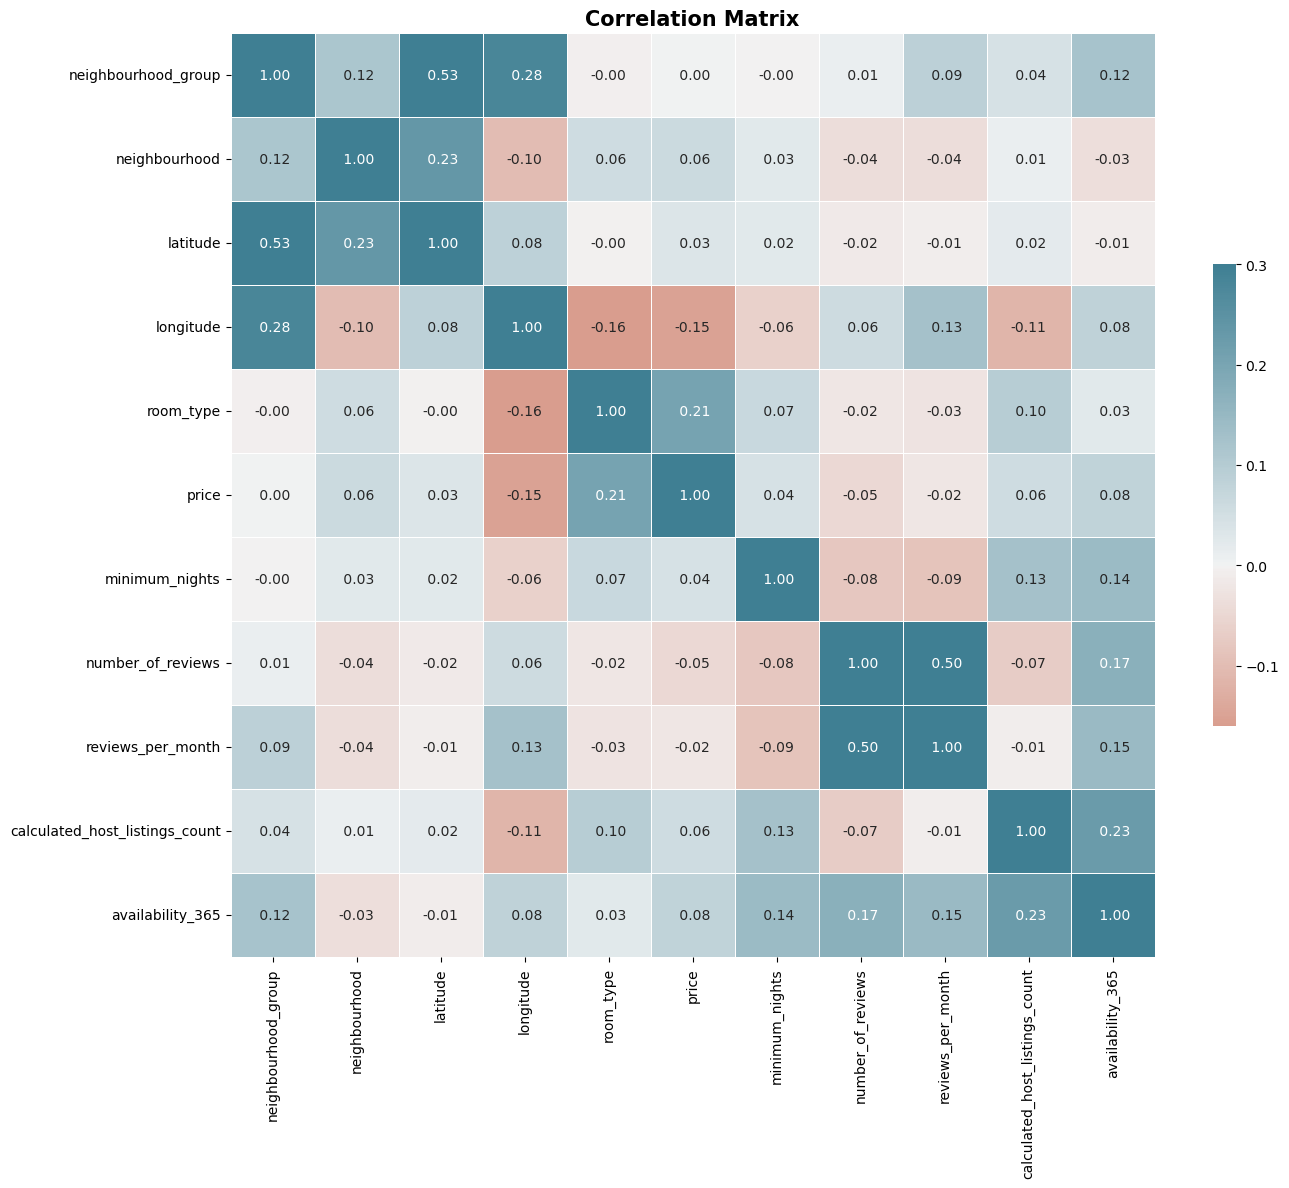

In [12]:
# Correlation table can be created and the Pearson method will be used:
plt.figure(figsize=(15,12))
palette = sns.diverging_palette(20, 220, n=256)
corr= df2.corr(method = 'pearson')
sns.heatmap(corr, annot= True, fmt= " .2f", cmap=palette, vmax = .3, center = 0,
            square=True, linewidths= .5, cbar_kws={"shrink": .5}).set(ylim=(11, 0))
plt.title("Correlation Matrix", size = 15, weight = 'bold')

# Observations from Correlation Table :
# Some of the regressor variables showing positive relationships are:
# 1.) latitude,
# 2.) minimum_nights,
# 3.) calculated_host_listings_count,
# 4.) availability_365,
# 5.) neighbourhood, 
# 6.) room_type, etc.
# Other features such as longitude, number_of_reviews, reviews_per_month are showing negative relationship with the target variable, price.

# Data Visualization Charts (Scatterplots) :

Text(0.5, 1.0, 'Price vs Neighbourhood vs Reviews')

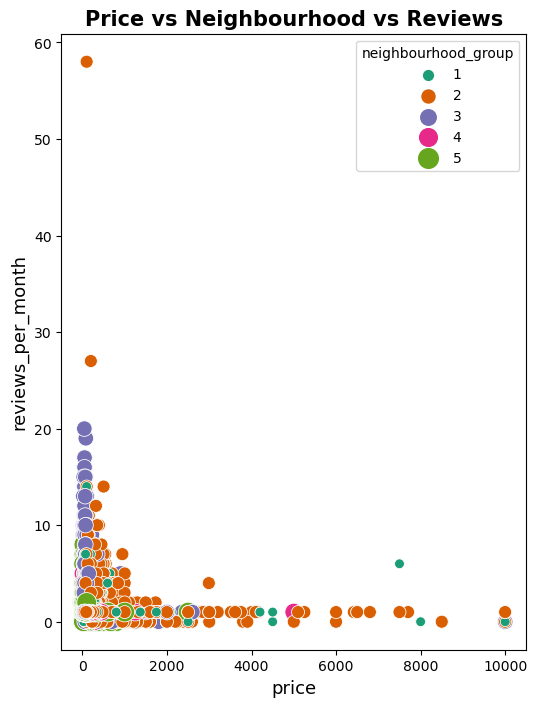

In [13]:
# Scatterplot to find out whether the price influences the reviews_per_month variable or not:
plt.figure(figsize=(6,8))
sns.scatterplot(x ='price',y='reviews_per_month',hue ="neighbourhood_group",size = "neighbourhood_group",sizes =(50,200),palette ="Dark2", data = df2)
# Naming the daigram :
plt.xlabel("price", size = 13)
plt.ylabel("reviews_per_month", size = 13)
plt.title("Price vs Neighbourhood vs Reviews", size = 15, weight = "bold")
# 1 for Brooklyn, 2 for Manhatten, 3 for Queens, 4 for Staten Island, 5 for Bronx.

# Observations :
# Customers paying more were found be giving lesser number of reviews a month and vice versa.
# hence there is a negative relationship in between price and reviews_per_month.
# On the contrary, customers paying less were found to be giving more number of reviews.
# There are one to two outliers, mainly from Brooklyn and Manhatten,customers who tend to pay more and were found giving reviews each month they book their stay as well maximum found in the above scatterplot.

Text(0.5, 1.0, 'Room_type vs Price vs Neighbouring_Group')

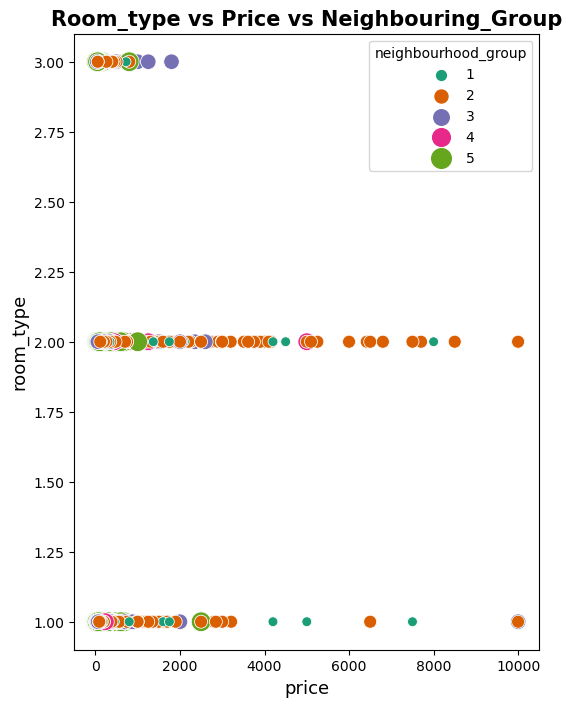

In [14]:
plt.figure(figsize=(6,8))
sns.scatterplot(x ='price', y = 'room_type', hue ="neighbourhood_group", size ="neighbourhood_group", sizes = (50,200), palette ="Dark2", data=df2)
# Naming the scatterplot daigram :
plt.xlabel("price", size = 13)
plt.ylabel("room_type", size = 13)
plt.title("Room_type vs Price vs Neighbouring_Group", size = 15, weight= "bold")
# hue' is used to visualize the data of different categories in one plot. 
# 'palette' is used to change the colour of the plot.
# Seaborn has six variations of its default color palette: deep , muted , pastel , bright , dark , and colorblind .

# Observation drawn by the scatterplot daigram:
# the price range is found to be higher for a private room or entire home/apt but only for Brooklyn and Manhattern locations,
# In case of shared rooms, the price range was observed to be around 2000 dollars only for Queens location.
# Manhatten and Brooklyn were found to be the most expensive locations when it comes to booking vacations with Airbnb.

Text(0.5, 1.0, 'Price vs Minimum Nights vs Neighbourhood Groups')

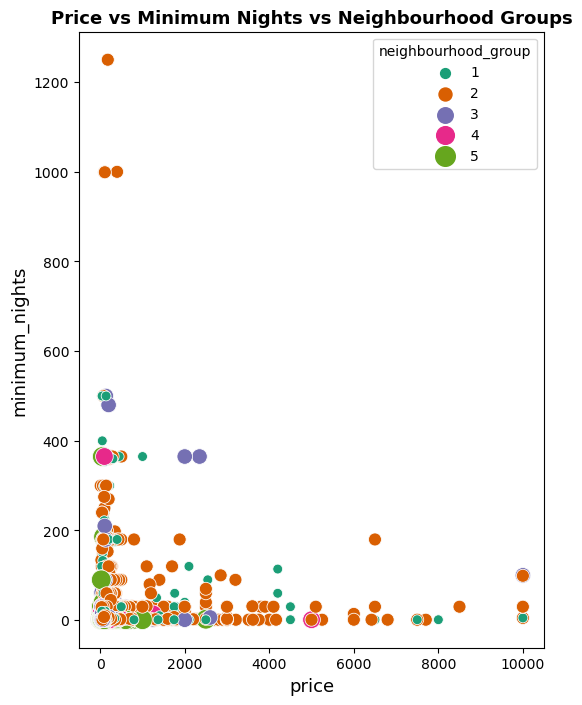

In [15]:
# Now we will plot the daigram for minimum_nights in a similar way:
plt.figure(figsize=(6,8))
sns.scatterplot(x = "price",y ="minimum_nights",hue ="neighbourhood_group",size ="neighbourhood_group",sizes =(50,200),palette="Dark2",data=df2)
# the minimum number of nights are going upto 1200, so we need to trim atleast 50 percent of the data to get rid of these three outliers.
# There are total three outliers for Brooklyn location who spend above 1000 to 1200 nights while booking for entire apartment and shared rooms.
plt.xlabel("price", size = 13)
plt.ylabel("minimum_nights", size = 13)
plt.title("Price vs Minimum Nights vs Neighbourhood Groups", size = 13, weight = "bold")

# Observation :
# We can observe that the minimum number of nights booked by the customer becomes minimum as price increases. 
# Hence, we can see price and minimum_nights showing a negligible positive relationship (0.04 as shown in the heat map).

Text(0.5, 1.0, 'Price vs Availability vs Neighbourhood Groups')

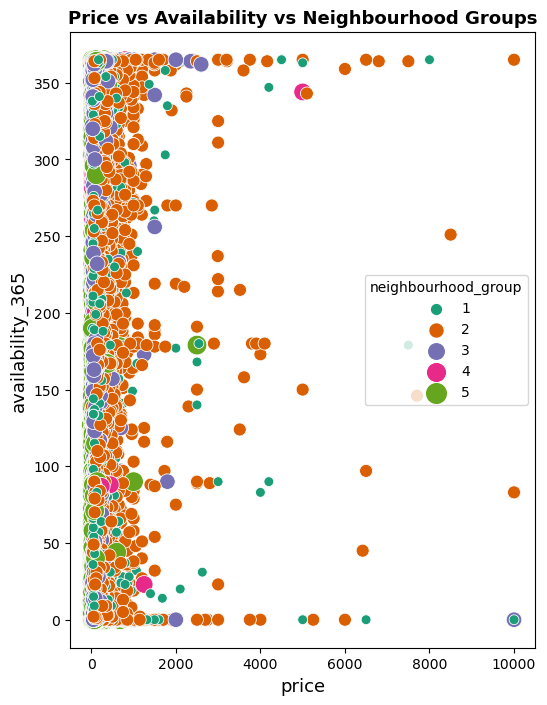

In [16]:
# Our last section of observation will be availability_365 :
plt.figure(figsize=(6,8))
sns.scatterplot(x="price",y="availability_365",hue="neighbourhood_group",size="neighbourhood_group",sizes=(50,200),palette= "Dark2", data=df2)
# Price increases availability decreases.
# We can observe here that there are total five outliers, for both Brooklyn and Manhatten with a price range of 8000 to 10000.
plt.xlabel("price", size = 13)
plt.ylabel("availability_365", size = 13)
plt.title("Price vs Availability vs Neighbourhood Groups", size = 13, weight = "bold")

# Observations:
# Price increases availability still manages to become minimum, but doesn't get reduced significantly.
# This is why we can say that price and availability showes a slightly positive relationship (0.08 as shown in the heatmap). 

Text(0.5, 1.0, 'Price Vs Calculated_host_listings_count Vs Neighbourhood_group')

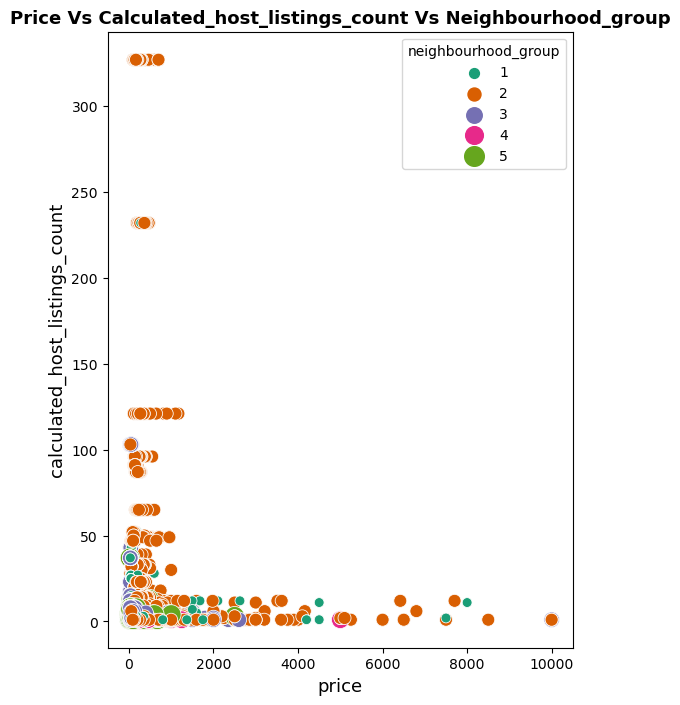

In [17]:
# Calculated_host_listings_count and price show a fairly positive relationship,so lets draw a scatter plot to check that as well:
plt.figure(figsize=(6,8))
sns.scatterplot(x='price',y='calculated_host_listings_count',hue ='neighbourhood_group',size='neighbourhood_group',sizes=(50,200),palette="Dark2",data=df2)
plt.xlabel("price", size= 13)
plt.ylabel("calculated_host_listings_count", size= 13)
plt.title("Price Vs Calculated_host_listings_count Vs Neighbourhood_group", size=13, weight="bold")

# Observations:
# The number of bookings becomes lesser as price of the rooms increases.
# This proves that there is a slightly positive relationship between price and calculated_host_listings_count (0.06) as per heatmap values.

# Trimming the Dataset/Dealing with Outliers - Quantile Regression

# Now that we have created a good visualization scatterplot charts showing the positive and negative relationships exist between target and regressor variables,we can now proceed further with using the Quantile Regression to analyse the distribution of the variate observations. 
# Quantile is the point in a data distribution or a percentile that divides a variable into 100 equal places.
# for instance, the middle value of such data is called the median,middle quantile or 50th percentile.
# Quantile Regression determines the median of a set of data accross a distribution based on variables within that distribution.
# Quantile Regression is highly effective as compared to linear regression while dealing with data containing outliers.
# There are other vital reasons on why to choose the Quantile Regression to analyse over Linear Regression:
# 1.) When linear regression assumption are meeting up with each other, for ex., data points showing a heteroscedasticity nature.
# 2.) When you have outliers in your data sample.
# 3.) To determine the median of a quantile within a dataset.
# 4.) When the error variables make your outcome variable spike up.
# 5.) When you have abnormal residuals.

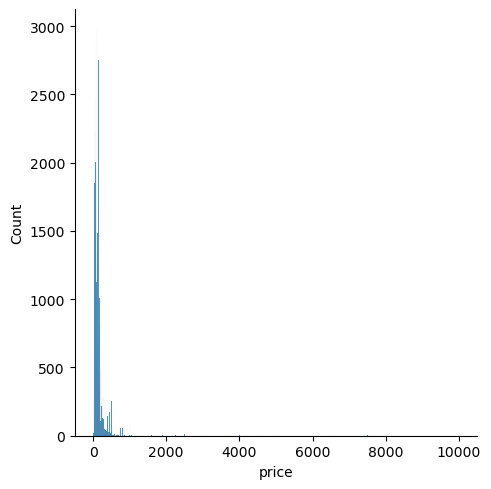

In [18]:
# As we can see that the maximum value is extremely high, pointing towards the outliers, which is why we need to check for 
# probability distribution function (i.e., PDF) :
sns.displot(df2['price'])
# Here, we can see that the graph shows an exponential distribution curve, 
# i.e., the graph shows a positive skewness.

# However, we can see in the above table while trying to describe the features, 
# the maximum value for price goes up to 10,000(an outlier), 
# minimum_nights goes upto 1250, 
# number_of_reviews goes upto 629,
# availability 365 goes up to 365, 
# calculated_host_listings_count goes up to 350 etc.
# Therefore, we need to trim the data to get rid of the outliers.
# Outliers are observations that lie mostly outside of the third quartile range(75% of the data), appearing far away from majority of data points.

<AxesSubplot:xlabel='price', ylabel='Count'>

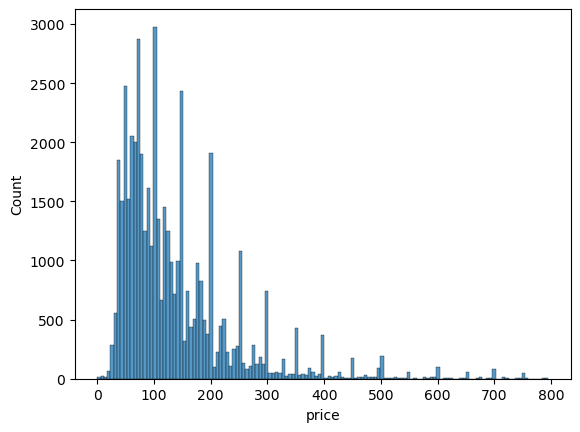

In [19]:
# Here, we can try to use the quantile regression analysis.
# One way to deal with outliers is to remove the top 1 % of the data from the price column.
# We will try to keep the data below 99% and this is how we can eliminate the outliers.
# We create a new variable which is q and assign the quantile function in order to get rid of the top 1% of the data:
q = df2['price'].quantile(0.99)
# Now that we created the q, we can create a new variable by forming a new dataset with only 99% of the dataset under price col.
df_99percent_price = df2[df2['price']<q]
# here, df_99percent_price was created and assigned only the rest 99% of the data, trimming the top 1% eliminating the outliers.
# Plotting the new created price range will give us a better idea of how the new 99 percent data is distributed on the graph:
df_99percent_price.describe(include = "all")
sns.histplot(df_99percent_price['price'])
# Now you can observe the distribution shows positive skewness still, removing the top 1 % will reduce the skewness.
# however, the price is now mostly found to be distributed in between 0 to 800 dollars, eliminating the outlier.

<AxesSubplot:xlabel='reviews_per_month', ylabel='Count'>

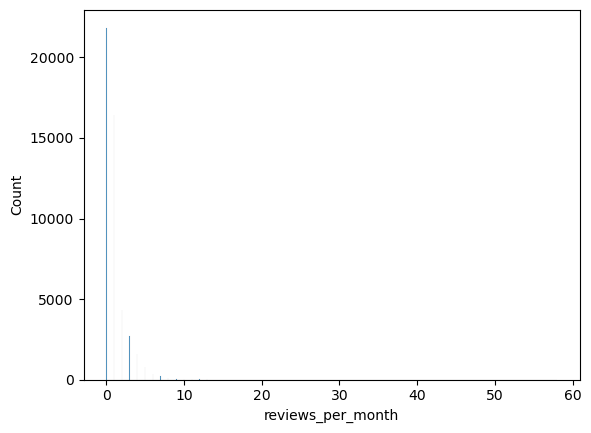

In [20]:
sns.histplot(df_99percent_price['reviews_per_month'])
# Below graph showing an exponential curve or postive skewness, which needs to be treated in a similar procedure as we did with price.

<AxesSubplot:xlabel='reviews_per_month', ylabel='Count'>

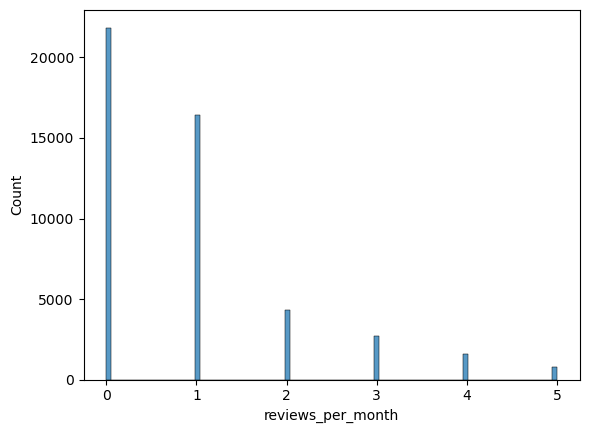

In [21]:
# Similarily, we will try to trim the data for the rest of the selected columns, 
# i.e., minimum_nights, number_of_reviews, availability_365, etc.
# We can see that the data points are quite distributed upto 629, 
# which is why we need to trim the top 1% of data to get rid of the outliers.
# Let's create another variable,p, so we can use the quantile function once again :
p = df_99percent_price['reviews_per_month'].quantile(0.99)
df_99percent_reviews = df_99percent_price[df_99percent_price['reviews_per_month']<p]
# Now we will plot the newly created data, df_99percent_reviews using sns:
sns.histplot(df_99percent_reviews['reviews_per_month'])

C:\Users\ASUS\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='minimum_nights', ylabel='Density'>

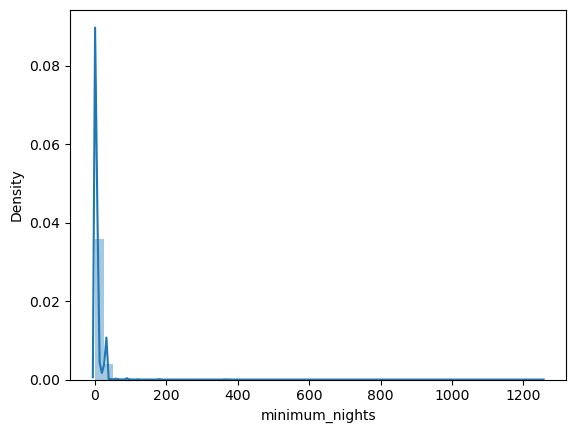

In [22]:
# We need to also exclude the outlier for minimum_nights:
sns.distplot(df_99percent_reviews['minimum_nights'])
# Outliers are somewhere at 1200.

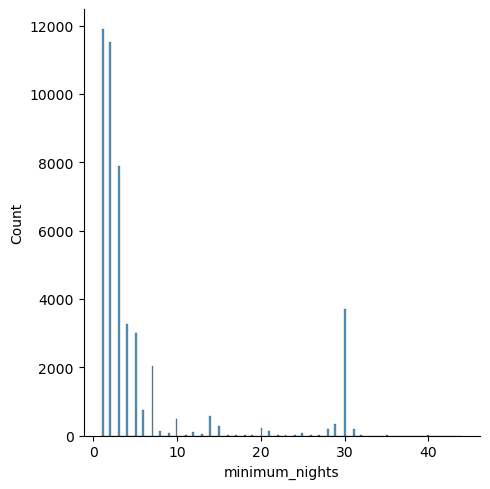

In [23]:
# As we have discussed, we need to trim the minimum_nights dataset,
# since there are only three outliers from Brooklyn location to take care of.
y = df_99percent_reviews['minimum_nights'].quantile(0.99)
df_99percent_minimum_nights = df_99percent_reviews[df_99percent_reviews['minimum_nights']<y]
sns.displot(df_99percent_minimum_nights['minimum_nights'])
# Removal of top 1% of data has caused us to get the maximum no of minimum nights upto 30.
# for an avg mean of 5, 30 is still acceptable.

C:\Users\ASUS\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='availability_365', ylabel='Density'>

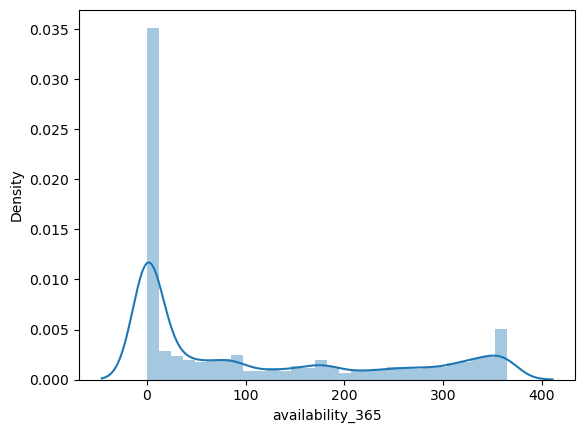

In [24]:
# Let's trim the data for availability_365 as well:
sns.distplot(df_99percent_minimum_nights['availability_365'])
# The distribution of the data is well beyond 350, which is 365.
# So here, the availability as per geographical data is 365 which refers to room types being available for that particular year.
# We will only trim the top 1%, so let's start.

<AxesSubplot:xlabel='availability_365', ylabel='Count'>

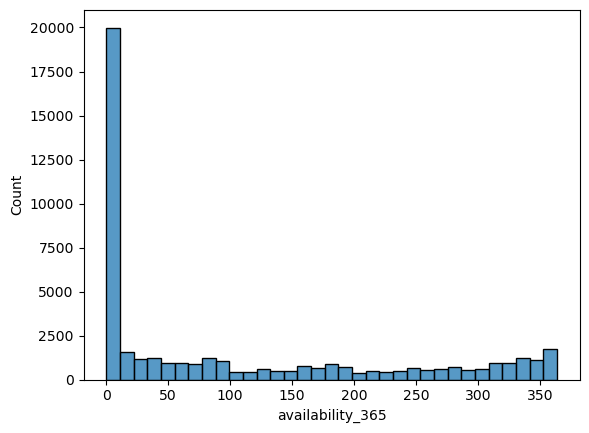

In [25]:
x = df_99percent_minimum_nights['availability_365'].quantile(0.99)
df3 = df_99percent_minimum_nights[df_99percent_minimum_nights['availability_365']<x]
sns.histplot(df3['availability_365'])
# In this case, if we remove the top 1% of the dataset in order to get rid of the outliers, 
# We remove the top 1% to get rid of the outliers and have the distribution conform to normality.

C:\Users\ASUS\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='calculated_host_listings_count', ylabel='Density'>

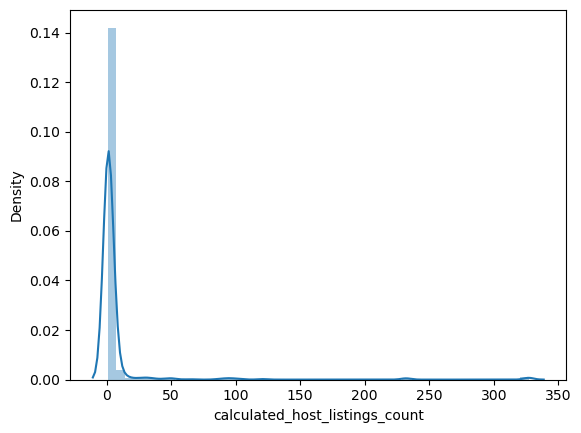

In [26]:
sns.distplot(df3['calculated_host_listings_count'])

C:\Users\ASUS\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='calculated_host_listings_count', ylabel='Density'>

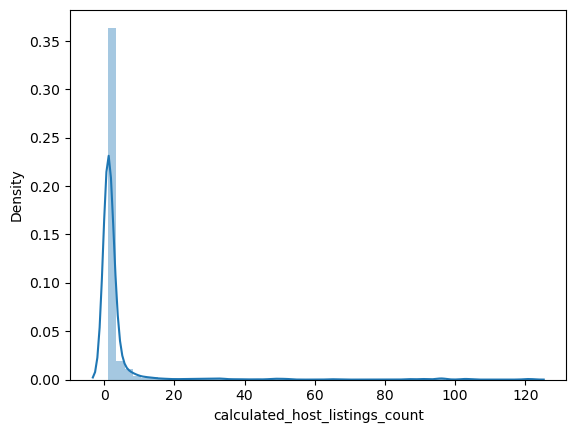

In [27]:
# In case of calculated_host_listings_count, we can observe that the data points are distributed in an exponential distribution curve.
# So we need to have the top 1% percent removed from the dataset.
w = df3['calculated_host_listings_count'].quantile(0.99)
df4 = df3[df3['calculated_host_listings_count']<w]
sns.distplot(df4['calculated_host_listings_count'])

In [28]:
# Now that our data is cleaned and ready to analyze, we can now create a new variable named data_cleaned and set up the index:
data_cleaned = df4.reset_index(drop=True)
data_cleaned.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,2,127,40.75362,-73.98377,2,225,1,45,0,2,355
1,1,41,40.68514,-73.95976,2,89,1,270,4,1,194
2,2,61,40.79851,-73.94399,2,80,10,9,0,1,0
3,2,137,40.74767,-73.97500,2,200,3,74,0,1,129
4,2,95,40.76489,-73.98493,1,79,2,430,3,1,220


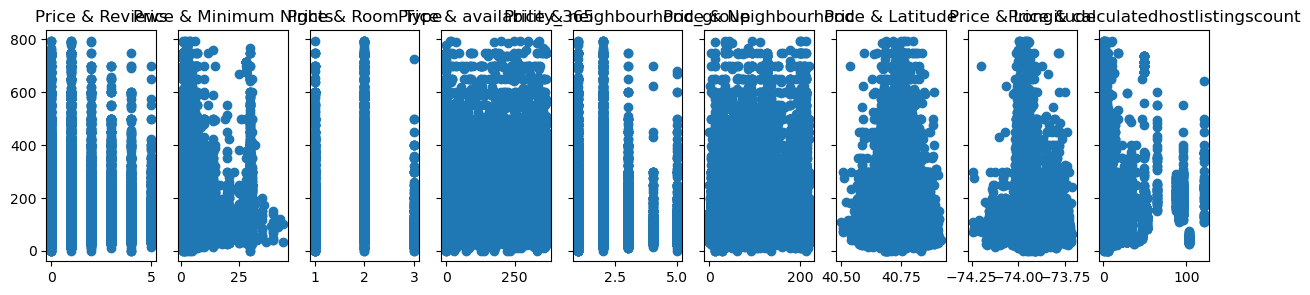

In [29]:
# Now its time for plotting the graph.
# In order to find whether the new transformed data is showing some sort of 
# co-relation in between the x (independent) and y (target) features, we have created three plots showing three axis:
fig, (ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9) = plt.subplots(1,9, sharey = True, figsize=(15,3))
ax1.scatter(data_cleaned['reviews_per_month'], data_cleaned['price'])
ax1.set_title('Price & Reviews')
ax2.scatter(data_cleaned['minimum_nights'], data_cleaned['price'])
ax2.set_title('Price & Minimum Nights')
ax3.scatter(data_cleaned['room_type'], data_cleaned['price'])
ax3.set_title('Price & Room Type')
ax4.scatter(data_cleaned['availability_365'], data_cleaned['price'])
ax4.set_title('Price & availability_365')
ax5.scatter(data_cleaned['neighbourhood_group'], data_cleaned['price'])
ax5.set_title('Price & neighbourhood_group')
ax6.scatter(data_cleaned['neighbourhood'], data_cleaned['price'])
ax6.set_title('Price & Neighbourhood')
ax7.scatter(data_cleaned['latitude'], data_cleaned['price'])
ax7.set_title('Price & Latitude')
ax8.scatter(data_cleaned['longitude'], data_cleaned['price'])
ax8.set_title('Price & Longitude')
ax9.scatter(data_cleaned['calculated_host_listings_count'], data_cleaned['price'])
ax9.set_title('Price & calculatedhostlistingscount')
plt.show()

<AxesSubplot:xlabel='price', ylabel='Count'>

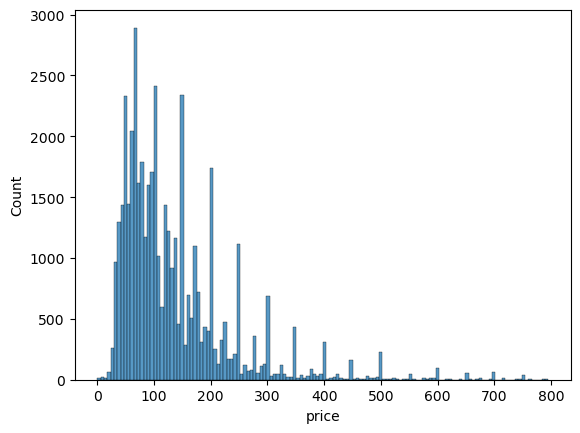

In [30]:
# We can observe here that data, we got after cleaning is showing positive skewness or distributed in an exponential curve.
# Therefore, we now have to use the log transformation in order to have the data points conform to normality.
sns.histplot(data_cleaned['price'])
# As per the graph, the data points are distributed in an exponential distribution curve.
# This also means that the regressor variables and target (price) is showing a very slight correlation.
# If we get the regressor variables and target form in a way that they are linearly correlated to each other, 
# then only it will help us to make predictions closer to the initial price values.

# In this particular case, we can see that there cannot be always the situation where we may have a linear relationship between the independent and dependent attributes. Hence, linear regression is a poor choice for dealing with such non-linear situations. This is where polynomial regression comes into picture.
# Polynomial Regression is a wonderful technique to encounter the situations where a quadratic, cubic or a higher degree non-linear relationship exists. The underlying concept in a polynomial regression is to add powers of each independent attribute as new attributes and then train the model by fitting the data to linear regression on the expanded collection of features.

# Log Transformation will make the data points conform to normality which, in turn, will reduce the skewness on the above graph.
# The above sns graph shows an exponential distribution curve, which is why, we are going to use log transformation to have the power of the observations increased.
# This will help us to make easier interpretation and better statistical analysis.

In [31]:
data_cleaned['log_price'] = np.log(data_cleaned.price+1)
data_cleaned
# Since division by zero could have given us a problem going formward, therefore, log+1 would be better.

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,log_price
0,2,127,40.75362,-73.98377,2,225,1,45,0,2,355,5.420535
1,1,41,40.68514,-73.95976,2,89,1,270,4,1,194,4.499810
2,2,61,40.79851,-73.94399,2,80,10,9,0,1,0,4.394449
3,2,137,40.74767,-73.97500,2,200,3,74,0,1,129,5.303305
4,2,95,40.76489,-73.98493,1,79,2,430,3,1,220,4.382027
...,...,...,...,...,...,...,...,...,...,...,...,...
45432,1,13,40.67853,-73.94995,1,70,2,0,1,2,9,4.262680
45433,1,28,40.70184,-73.93317,1,40,4,0,1,2,36,3.713572
45434,2,94,40.81475,-73.94867,2,115,10,0,1,1,27,4.753590
45435,2,95,40.75751,-73.99112,3,55,1,0,1,6,2,4.025352


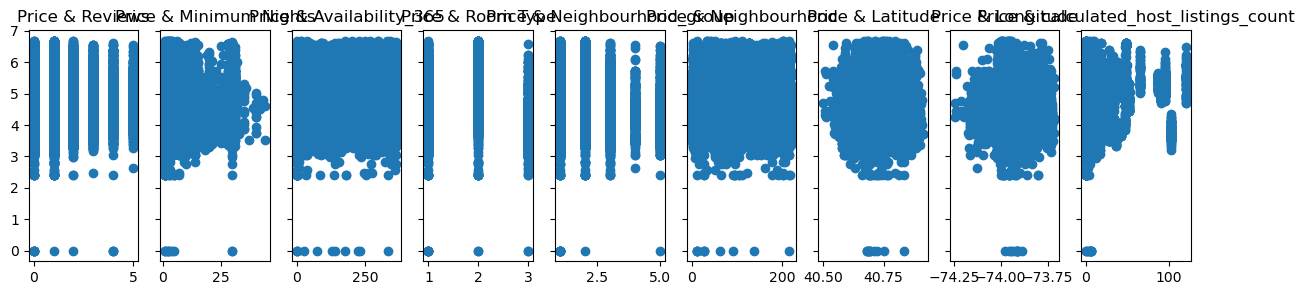

In [32]:
# Once we create an additional column for log_price, it is time for us to incorporate the same to form the subplots:
fig, (ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9) = plt.subplots(1,9, sharey = True, figsize = (15,3))
ax1.scatter(data_cleaned['reviews_per_month'],data_cleaned['log_price'])
ax1.set_title('Price & Reviews')
ax2.scatter(data_cleaned['minimum_nights'],data_cleaned['log_price'])
ax2.set_title('Price & Minimum Nights')
ax3.scatter(data_cleaned['availability_365'],data_cleaned['log_price'])
ax3.set_title('Price & Availability_365')
ax4.scatter(data_cleaned['room_type'], data_cleaned['log_price'])
ax4.set_title('Price & Room Type')
ax5.scatter(data_cleaned['neighbourhood_group'], data_cleaned['log_price'])
ax5.set_title('Price & Neighbourhood_group')
ax6.scatter(data_cleaned['neighbourhood'], data_cleaned['log_price'])
ax6.set_title('Price & Neighbourhood')
ax7.scatter(data_cleaned['latitude'], data_cleaned['log_price'])
ax7.set_title('Price & Latitude')
ax8.scatter(data_cleaned['longitude'], data_cleaned['log_price'])
ax8.set_title('Price & Longitude')
ax9.scatter(data_cleaned['calculated_host_listings_count'], data_cleaned['log_price'])
ax9.set_title('Price & calculated_host_listings_count')
plt.show()
# As we can see that even after getting the logorithmic price included in our data, we can still see that none of the features 
# shows a strong positive relationship with the newly created log_price or 
# in other words, the regressor variables doesn't affect the target variable, log of price values.
# any change in the data points within any independent variables doesn't affect the target variable, log_price column.

<AxesSubplot:xlabel='log_price', ylabel='Count'>

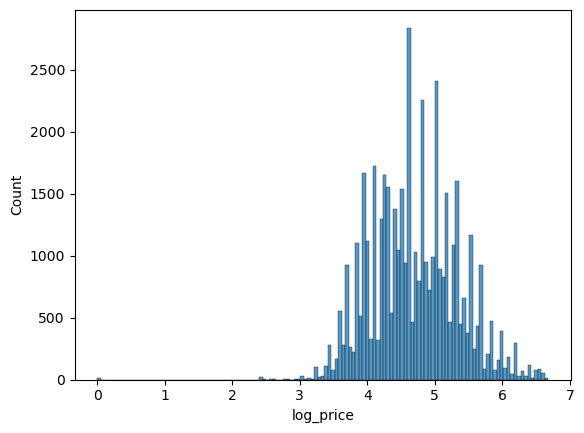

In [33]:
sns.histplot(data_cleaned['log_price'])
# Indicating a good fit showing that normality is a reasonable approximation.
# However, the above graph has shown us that none of the above feature has a strong relationship with logorithmic price, 
# but do have a slightly positive relationship.
# This is why the data points are distributed in a more or less normally distributed curve.

# Now we will start with checking for multi-collinearity in between the regressor variables. 
# Multi-collinearity exists when there is a relationship between the regressor variables.
# Multi-collinearity can be a great issue if these regressor variables have a positive relationship with each other.
# If multi-collinearity exists, it might create a problem while ranking the most affecting variable against the log_price column.

In [34]:
data_cleaned.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,log_price
0,2,127,40.75362,-73.98377,2,225,1,45,0,2,355,5.420535
1,1,41,40.68514,-73.95976,2,89,1,270,4,1,194,4.499810
2,2,61,40.79851,-73.94399,2,80,10,9,0,1,0,4.394449
3,2,137,40.74767,-73.97500,2,200,3,74,0,1,129,5.303305
4,2,95,40.76489,-73.98493,1,79,2,430,3,1,220,4.382027


In [35]:
# In order to check for multi-collinearity, we can make the use of VIF (Variance Inflation Factor):
# We have already called the package before, so we will straight away jump into creation of object and start assigning variables:
Variables = data_cleaned[['room_type','minimum_nights','reviews_per_month','availability_365']] # to check if collinearity exists.
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(Variables.values, i) for i in range(Variables.shape[1])]
vif["Features"] = Variables.columns
Variables.shape[1]

4

In [36]:
vif
# As we can see from the below vif table, we can observe that multi-colinearity doesn't exists in between the features.

,VIF,Features
0,2.271489,room_type
1,1.622903,minimum_nights
2,1.671142,reviews_per_month
3,1.812958,availability_365


In [37]:
data_cleaned1 = data_cleaned.drop(['price'], axis = 1)
data_no_mutlicolinearity = data_cleaned1
# data_no_mutlicolinearity.info()
# Before moving on, we need to have the log_price converted into an integer so the data can get scaled properly.
data_cleaned1.tail()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,log_price
45432,1,13,40.67853,-73.94995,1,2,0,1,2,9,4.262680
45433,1,28,40.70184,-73.93317,1,4,0,1,2,36,3.713572
45434,2,94,40.81475,-73.94867,2,10,0,1,1,27,4.753590
45435,2,95,40.75751,-73.99112,3,1,0,1,6,2,4.025352
45436,2,95,40.76404,-73.98933,1,7,0,1,1,23,4.510860


# Starting with the Prediction:

In [38]:
# We need to now get the feature columns defined to start with the training and testing data split:
X = data_cleaned1.drop(['log_price'], axis = 1)
Y = data_cleaned1.log_price

In [39]:
# Check the heads of two variables defined:
X.isnull().sum()
#Y
# Succesfully segregated both the variables.

neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
dtype: int64

In [40]:
# Starting with Standardizing the Variables before splitting it into train & test dataset:
scaler = StandardScaler(with_mean=False)
# Fitting the data with an intent to scale it:
scaler.fit(X)

StandardScaler(with_mean=False)

In [41]:
# Next step is to transform the data to get a standardized dataset:
X_Scaled = scaler.transform(X)

In [42]:
# Splitting the data into training and testing dataset:
x_train, x_test, y_train, y_test = train_test_split(X_Scaled, Y, test_size = 0.3, random_state= 13)

In [43]:
reg = LinearRegression()

In [44]:
reg.fit(x_train,y_train)

LinearRegression()

In [45]:
# Now we will try to get the prediction results by using reg.score:
reg.score(x_train, y_train)
# As we can see the prediction score are coming very less as we are conducting our analysis on non linear data.

0.34003468116128244

In [46]:
# No we will try with the test dataset:
reg.score(x_test, y_test)
# Same happens with the testing dataset.

0.35362011714074804

In [47]:
# Once you have fitted the training data to linear regression, we will now create y_pred(to predict the training data):
y_pred = reg.predict(x_train)

In [48]:
y_pred1 = reg.predict(x_test)
y_pred1

array([5.1540548 , 5.12848175, 4.40609702, ..., 4.24553311, 3.63115883,
       5.12369255])

C:\Users\ASUS\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Residuals.PDF')

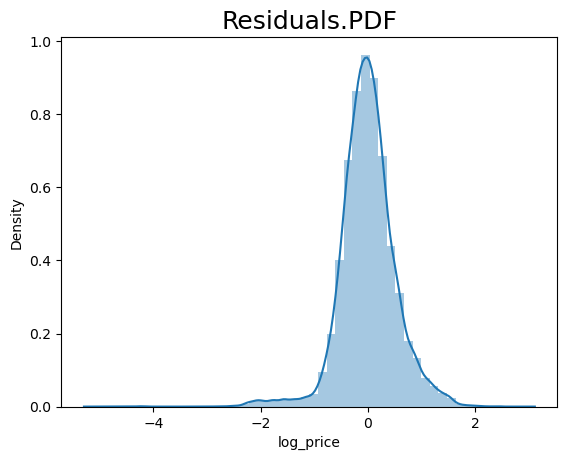

In [49]:
# Lets plot the residuals:
Residuals = y_train-y_pred
sns.distplot(Residuals)
plt.title("Residuals.PDF", size = 18)

In [50]:
# Now its time to plot the reg_summary results by including the intercept and the coefficient:
reg.intercept_

-326.5239288841877

In [51]:
reg.coef_

array([-0.02400111,  0.04669238,  0.07517292, -0.16717454,  0.29750324,
       -0.0611548 , -0.02734221,  0.0092637 ,  0.01423787,  0.07459337])

In [52]:
reg_summary = pd.DataFrame(X.columns.values, columns = ['Features'])
reg_summary['Weights'] = reg.coef_
reg_summary

,Features,Weights
0,neighbourhood_group,-0.024001
1,neighbourhood,0.046692
2,latitude,0.075173
3,longitude,-0.167175
4,room_type,0.297503
5,minimum_nights,-0.061155
6,number_of_reviews,-0.027342
7,reviews_per_month,0.009264
8,calculated_host_listings_count,0.014238
9,availability_365,0.074593


# Observation:
# You can observe positive values only for room_type and availability_365, neighbourhood, latitude, reviews_per_month, calculated_host_listings_count, etc.
# This means with the change in room_type, neighbourhood, latitude, reviews_per_month, calculated_host_listings_count,  and availability ratios, price gets affected.
# As we know that if rooms will not be available, the customers won't be able to book the rooms.
# As we can observe from the scatterplot above, we can see that customers mainly book their vacations for an entire apt/private rooms,
# mainly from Manhatten and Brooklyn, etc and these Entire apt/home and private rooms have limited availability issues which needs to be tracked down.
# Hence, availability 365 is the main attribute of our interest and our opportunity statement.
# Creating customer segmentation into different clusters or performing a cluster analysis can be beneficial to find out the pain points and how we need to overcome the challenges as well.

# Observations:
# There are some negative results for some of the features,neighbouring_group,minimum_nights and reviews_per_month, etc.
# These features are not getting affected by the target, log_price, which is why its showing the result in minus.

C:\Users\ASUS\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Weights', ylabel='Density'>

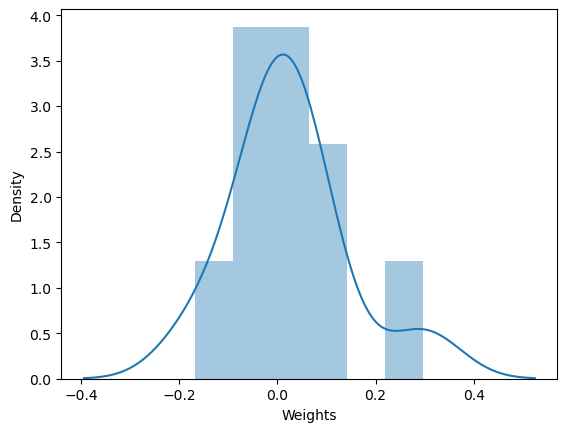

In [53]:
sns.distplot(reg_summary['Weights'])

In [54]:
# We will try to carry out some predictions on non linear dataset:
df_pf = pd.DataFrame((y_pred1), columns=['Predictions'])
df_pf.tail()

,Predictions
13627,4.478616
13628,5.006282
13629,4.245533
13630,3.631159
13631,5.123693


In [55]:
# In order to find the actual predictions, we will use exponential function to get the exact predictions,
df_pf = pd.DataFrame(np.exp(y_pred1), columns = ['Predictions'])
df_pf.head(5)
# Initially, while applying the log function we added 1 so we are now substracting 1 from the predicted values to get the actual predicted values.

,Predictions
0,173.132084
1,168.760702
2,81.948993
3,124.041823
4,104.460874


In [56]:
y_test = y_test.reset_index(drop = True)

In [57]:
y_test
df_pf['Targets'] = np.exp(y_test)
df_pf

,Predictions,Targets
0,173.132084,160.0
1,168.760702,126.0
2,81.948993,66.0
3,124.041823,101.0
4,104.460874,201.0
...,...,...
13627,88.112613,51.0
13628,149.348352,226.0
13629,69.792958,91.0
13630,37.756545,46.0


In [58]:
df_pf['Residuals'] = df_pf['Targets']-df_pf['Predictions']
df_pf

,Predictions,Targets,Residuals
0,173.132084,160.0,-13.132084
1,168.760702,126.0,-42.760702
2,81.948993,66.0,-15.948993
3,124.041823,101.0,-23.041823
4,104.460874,201.0,96.539126
...,...,...,...
13627,88.112613,51.0,-37.112613
13628,149.348352,226.0,76.651648
13629,69.792958,91.0,21.207042
13630,37.756545,46.0,8.243455


In [59]:
df_pf['Differences'] = np.absolute(df_pf['Residuals']/df_pf['Targets']*100)
df_pf

,Predictions,Targets,Residuals,Differences
0,173.132084,160.0,-13.132084,8.207553
1,168.760702,126.0,-42.760702,33.937065
2,81.948993,66.0,-15.948993,24.165141
3,124.041823,101.0,-23.041823,22.813687
4,104.460874,201.0,96.539126,48.029416
...,...,...,...,...
13627,88.112613,51.0,-37.112613,72.769830
13628,149.348352,226.0,76.651648,33.916658
13629,69.792958,91.0,21.207042,23.304442
13630,37.756545,46.0,8.243455,17.920555


In [60]:
# Comparing the prediction results with the initial datapoint observations:
df_pf['Initial_Price'] = df2['price']
df_pf
# Predictions are more or less very closer to the actual price range.
# This means there is an underfitting situation, which explains the cause.
# Training dataset is not performing accurate however test data is found to be closer to actual price range.

,Predictions,Targets,Residuals,Differences,Initial_Price
0,173.132084,160.0,-13.132084,8.207553,149
1,168.760702,126.0,-42.760702,33.937065,225
2,81.948993,66.0,-15.948993,24.165141,150
3,124.041823,101.0,-23.041823,22.813687,89
4,104.460874,201.0,96.539126,48.029416,80
...,...,...,...,...,...
13627,88.112613,51.0,-37.112613,72.769830,70
13628,149.348352,226.0,76.651648,33.916658,220
13629,69.792958,91.0,21.207042,23.304442,135
13630,37.756545,46.0,8.243455,17.920555,140


# Observations:
# We can experience an underfitting issue, which shows us that training data is not able to predict properly,
# However, the testing dataset is able to make predictions closer to initial price values.

# We will now move ahead to perform the cluster analysis to understand how many optimum number of clusters could be formed out of the given data.
# We also need to find the solution to the existing limited availability problem for entire apt/private homes mainly in areas like Manhatten and Brooklyn.
# Company will be able to make huge profit if they are successful in tracking down the availability issue in these areas as the booking price will be higher as compared to the rest of the areas.

In [64]:
from sklearn.cluster import KMeans

In [65]:
model=KMeans(n_clusters=4,random_state=9)

In [66]:
data = df2.drop(['latitude','longitude'], axis = 1)

In [67]:
model.fit(data)

KMeans(n_clusters=4, random_state=9)

In [68]:
model.predict(data)

array([0, 0, 0, ..., 1, 1, 1])

In [69]:
# Getting group wise summary on the clusters
data['sum1']=model.predict(data) # here sum1 refers to the clusters created based upon the main dataset.

In [70]:
data.groupby('sum1').mean()
# groupby function helped to get the mean (average values) for identifying the types of customers in each of the four clusters.

,neighbourhood_group,neighbourhood,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
sum1,,,,,,,,,
0,1.907264,103.585122,1.591488,147.100786,10.648527,35.045806,1.274900,17.033138,281.300112
1,1.724640,108.426331,1.546274,125.160551,5.142079,17.747714,0.885034,2.125235,26.127145
2,1.790698,108.976744,1.860465,5845.860465,21.232558,1.953488,0.767442,3.093023,190.186047
3,1.854730,123.980856,1.862613,969.746622,8.949324,10.681306,0.837838,9.406532,184.922297


In [71]:
from sklearn.preprocessing import StandardScaler 
# first we have to standardise the data for which had to import the StandardScaler.

In [72]:
scaler= StandardScaler()

In [73]:
scaler.fit(data) # Now that we have standardized the data, the next step would be to transform the data into a numpy array.

StandardScaler()

In [74]:
data_c= scaler.transform(data) 
# in order to get better predictive results we have transformed the main dataset into a standardized one, 
# coverting into a numpy array.

In [75]:
data_c # you can see that the df dataset has transformed into a numpy array.

array([[-0.93194198,  0.01276167, -1.04779696, ..., -0.03471643,
         1.91625031, -1.26042248],
       [ 0.2523626 ,  0.28915589,  0.79980058, ..., -0.15610444,
         1.84027456, -1.26042248],
       [ 0.2523626 , -0.19089723, -1.04779696, ..., -0.18645145,
         1.91625031, -1.26042248],
       ...,
       [ 0.2523626 , -0.19089723,  0.79980058, ..., -0.18645145,
        -0.65173008,  0.51612284],
       [ 0.2523626 , -0.17635016,  2.64739813, ..., -0.03471643,
        -0.84166946,  0.51612284],
       [ 0.2523626 , -0.17635016, -1.04779696, ..., -0.18645145,
        -0.68212038,  0.51612284]])

In [76]:
model.fit(data_c)

KMeans(n_clusters=4, random_state=9)

In [77]:
model.predict(data_c) # here we are having the predictive values for each customers seperating them into different cluster groups.

array([0, 0, 0, ..., 2, 2, 2])

In [78]:
df4=pd.DataFrame(data_c) 

In [79]:
df4.columns = data.columns

# Now that we have created a new dataset df4, 
# the next step will be to create clusters for grouping the customers based on their consumption.

In [80]:
df4['cluster']=model.predict(data_c)

In [81]:
df4.groupby('cluster').mean() # have grouped the customers according to the predictive values for each cluster.

,neighbourhood_group,neighbourhood,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,sum1
cluster,,,,,,,,,,
0,0.147407,-0.040528,0.021476,-0.029207,0.273169,-0.135688,-0.140848,0.063756,1.312271,-1.255229
1,0.103231,-0.099586,-0.077262,-0.134193,-0.224931,2.027791,1.952228,-0.153594,0.297373,-0.312123
2,-0.087362,0.034914,-0.009793,0.027550,-0.090824,-0.299324,-0.293532,-0.158888,-0.647913,0.621275
3,0.248125,0.038525,0.773359,0.504713,0.688448,-0.469830,0.072240,8.510164,1.283395,-1.041135


In [82]:
df5=df4.drop(['sum1'], axis=1)

In [83]:
df5.head()

,neighbourhood_group,neighbourhood,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,cluster
0,-0.931942,0.012762,-1.047797,-0.015493,-0.293996,-0.320414,-0.699893,-0.034716,1.916250,0
1,0.252363,0.289156,0.799801,0.300974,-0.293996,0.487665,-0.699893,-0.156104,1.840275,0
2,0.252363,-0.190897,-1.047797,-0.011329,-0.196484,-0.522433,-0.008191,-0.186451,1.916250,0
3,-0.931942,-0.961892,0.799801,-0.265335,-0.293996,5.538156,2.066916,-0.186451,0.617065,1
4,0.252363,-0.670950,0.799801,-0.302811,0.144807,-0.320414,-0.699893,-0.186451,-0.856865,2


In [84]:
df5.cluster.unique()

array([0, 1, 2, 3])

In [85]:
# As we have dropped the sum1 columns from the dataset, we will now have to create clusters 
# and start grouping the customers into those clusters.

groups=df5.groupby('cluster') 

In [86]:
cluster1=groups.get_group(0)
cluster2=groups.get_group(1)
cluster3=groups.get_group(2)
cluster4=groups.get_group(3)

In [87]:
# Now we will try to analyse the groups into which the customers are placed seperately:
# Selected 5 random customers for analysing the ist cluster
# which included a set of customers belonging to Brooklyn(40%) and Manhatten(60%), 
# These customers were found to be booking an entire house/apt and giving fair amount of reviews/feedbacks per month.
# However, these customers stayed for a little longer (for 8-9 nights on an average.)
cluster1.sample(5,random_state=13)

,neighbourhood_group,neighbourhood,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,cluster
2402,-0.931942,-0.685497,-1.047797,-0.265335,-0.245240,-0.522433,-0.008191,-0.186451,1.916250,0
33706,-0.931942,-0.263633,0.799801,-0.319468,-0.245240,0.061179,0.683511,-0.186451,1.597152,0
8043,-0.931942,1.554750,0.799801,0.196873,-0.196484,0.150966,-0.699893,-0.186451,1.908653,0
23459,-0.931942,0.740115,-1.047797,-0.281991,-0.196484,-0.455093,-0.699893,-0.186451,0.579077,0
23746,-0.931942,-0.801874,-1.047797,-0.365272,-0.196484,-0.006161,-0.699893,-0.125757,1.581957,0


In [88]:
cluster2.sample(5,random_state=13)
# Observations :
# found that 40% of the customers were coming from Manhatten, 40% from Brooklyn and 10% from Queens,
# Minimum nights were on an average found to be around 7-8 nights,
# People spended moderate amounts on rooms. 
# There were no reviews put up by the customers from Queens,
# It has been observed that the customers tend to book low cost apartments for their longer stay.
# Opportunity statement we need to work on - 
# 1) Availability is an issue which should be taken care of for low cost apartments (50,33,etc.)
# 2) Customers from Queens donot tend to submit any reviews. Availability is also zero for them (Main issue),
# 3) Mostly people are coming from Brooklyn and Manhatten and very rarely from Queens, which makes them brand new customers.
# 4) Customers coming from Queens can be the potential ones as they stay for longer period of time (30)
# So if the company pays more attention to the availability part,this can help them achieve higher sales revenue 
#    and even encourage more customers to book their stay in Airbnb from Queens.
# Three advantages:
# 1) New lead generation
# 2) Spreading awareness amongst consumers(in terms of market footprints tapping the potential crowd.)
# 3) Improve customer reviews

,neighbourhood_group,neighbourhood,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,cluster
13325,-0.931942,1.554750,-1.047797,-0.265335,-0.293996,1.632443,0.683511,-0.125757,0.943761,1
30379,1.436667,0.769209,-1.047797,-0.323632,-0.245240,1.385530,2.758618,-0.156104,1.794689,1
937,0.252363,-1.049174,0.799801,-0.098774,-0.196484,2.440521,-0.008191,-0.186451,0.442321,1
36257,0.252363,-1.063721,0.799801,0.563308,-0.196484,0.465218,2.066916,-0.186451,-0.492181,1
8852,-0.931942,-0.685497,0.799801,-0.219531,-0.245240,3.001687,1.375214,-0.156104,1.741506,1


In [89]:
cluster3.sample(5,random_state=13)
# Observations :
# These customers were mostly coming from Manhatten (10%), Brooklyn (60%), Queens(10%) 
# and were found to be booking the entire house/apt(90%) and private room(10%),
# Number of nights were on an average found to be 8-9 nights,
# Number of reviews were found to be descent.
# These set of customers were found to be spending little higher than usual for an entire house/apt,
# Similarily, we can observe that the customers coming from Queens are giving their feedbacks/reviews in cluster 3 unlike 2,
# Availability is also high for them.
# Hence, it proves that if the company wants to increase the customer base for Queens, they have to keep the rooms available.

,neighbourhood_group,neighbourhood,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,cluster
36017,0.252363,-1.020080,-1.047797,-0.136250,-0.098973,-0.410200,-0.699893,-0.186451,-0.666925,2
30341,-0.931942,-1.281927,-1.047797,-0.406912,0.388586,-0.522433,-0.008191,-0.186451,-0.856865,2
34324,0.252363,0.070950,0.799801,-0.177890,-0.293996,0.420325,1.375214,-0.186451,-0.796084,2
8634,0.252363,1.438374,0.799801,-0.057133,-0.147729,-0.455093,-0.699893,-0.186451,-0.856865,2
40552,0.252363,1.365639,-1.047797,-0.461045,-0.196484,-0.365307,-0.008191,-0.186451,0.138418,2


In [90]:
cluster4.sample(5,random_state=13)

,neighbourhood_group,neighbourhood,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,cluster
45939,0.252363,-0.496386,0.799801,0.092772,1.071169,-0.522433,-0.008191,9.706672,-0.575754,3
39769,0.252363,0.434627,0.799801,0.455043,-0.245240,-0.342860,-0.008191,9.706672,-0.165485,3
38683,0.252363,-1.063721,0.799801,0.754853,1.119925,-0.499987,-0.699893,6.823707,1.498384,3
38746,0.252363,-1.063721,0.799801,0.425895,1.119925,-0.499987,-0.699893,6.823707,1.650335,3
41364,0.252363,-0.496386,-1.047797,0.196873,-0.245240,-0.230627,0.683511,9.706672,1.817482,3


# Now in order to draw an elbow daigram (to determine the optimal number of clusters) through KMeans clustering method.
# to check which columns/features are relevant to draw the elbow daigram. "

In [91]:
# as the Id and cluster column was not required for drawing the elbow daigram,
# therefore, have used the drop fuction to remove both the columns from the dataset and saved the same by creating a new variable,df3,
df6=df5.drop(['cluster'],axis=1)

In [92]:
df6.head() # here we will consider taking only those features used for the analysis part..

,neighbourhood_group,neighbourhood,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,-0.931942,0.012762,-1.047797,-0.015493,-0.293996,-0.320414,-0.699893,-0.034716,1.916250
1,0.252363,0.289156,0.799801,0.300974,-0.293996,0.487665,-0.699893,-0.156104,1.840275
2,0.252363,-0.190897,-1.047797,-0.011329,-0.196484,-0.522433,-0.008191,-0.186451,1.916250
3,-0.931942,-0.961892,0.799801,-0.265335,-0.293996,5.538156,2.066916,-0.186451,0.617065
4,0.252363,-0.670950,0.799801,-0.302811,0.144807,-0.320414,-0.699893,-0.186451,-0.856865


In [93]:
# Importing the minmaxscaler function to scale the dataset.
from sklearn.preprocessing import MinMaxScaler

In [94]:
# here used the minmaxscaler to transform the data into a standardized one and saved it under the name of data_transformed.
mms = MinMaxScaler()
mms.fit(df6)
data_transformed = mms.transform(df6)

In [95]:
# it shows that the data_transformed is a numpy array,
data_transformed

array([[0.        , 0.49090909, 0.        , ..., 0.        , 0.01533742,
        1.        ],
       [0.25      , 0.57727273, 0.5       , ..., 0.        , 0.00306748,
        0.97260274],
       [0.25      , 0.42727273, 0.        , ..., 0.01724138, 0.        ,
        1.        ],
       ...,
       [0.25      , 0.42727273, 0.5       , ..., 0.01724138, 0.        ,
        0.0739726 ],
       [0.25      , 0.43181818, 1.        , ..., 0.01724138, 0.01533742,
        0.00547945],
       [0.25      , 0.43181818, 0.        , ..., 0.01724138, 0.        ,
        0.0630137 ]])

In [96]:
# Conversion of the numpy array into a DataFrame,
data_transformed=pd.DataFrame(data_transformed, columns=['neighbourhood_group','neighbourhood','room_type','price','minimum_nights','number_of_reviews','calculated_host_listings_count','reviews_per_month','availability_365'])
data_transformed

,neighbourhood_group,neighbourhood,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,reviews_per_month,availability_365
0,0.00,0.490909,0.0,0.0149,0.000000,0.014308,0.000000,0.015337,1.000000
1,0.25,0.577273,0.5,0.0225,0.000000,0.071542,0.000000,0.003067,0.972603
2,0.25,0.427273,0.0,0.0150,0.001601,0.000000,0.017241,0.000000,1.000000
3,0.00,0.186364,0.5,0.0089,0.000000,0.429253,0.068966,0.000000,0.531507
4,0.25,0.277273,0.5,0.0080,0.007206,0.014308,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
48890,0.00,0.059091,0.0,0.0070,0.000801,0.000000,0.017241,0.003067,0.024658
48891,0.00,0.127273,0.0,0.0040,0.002402,0.000000,0.017241,0.003067,0.098630
48892,0.25,0.427273,0.5,0.0115,0.007206,0.000000,0.017241,0.000000,0.073973
48893,0.25,0.431818,1.0,0.0055,0.000000,0.000000,0.017241,0.015337,0.005479


In [97]:
# model.inertia will give the within cluster sum of squares distance ()
model.inertia_

326106.35699968965

In [98]:
# Elbow Method to minimise WSS (Within sum of squared distances):
Sum_of_squared_distances = []
K = range (1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(data_transformed)
    Sum_of_squared_distances.append(km.inertia_)

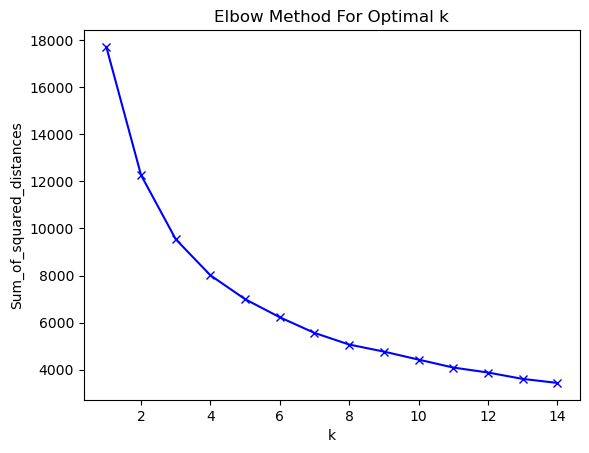

In [99]:
# Plotting the elbow daigram with k(number of clusters) on the x axis and sum of squared distances on the y axis,
# in this case, we have got the k value as 3 as shown below,
# this means that there are possibly 3 types of customers, 
# Cluster 2 shows that the availability is the main issue for low cost private rooms why customers coming from Queens
# are not providing their feedbacks/reviews,
# Queens customers can be the potential ones to get high sales for low cost private rooms,
# Cluster 3 shows their intent to give fair amount of reviews when the availability was good,
# Cluster 4 however shows a slight different case, 
# where the customers booking an entire house/ apt for higher rates didnt post any reviews due to non availability of rooms,
# Therefore,i would like to conclude that the company must have a check on the availability area 
# so that these three things can be achieved :
# Three advantages:
# 1) New lead generation
# 2) Spreading awareness amongst consumers(in terms of market footprints tapping the potential crowd (Queens consumers)).
# 3) Improve customer reviews

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [100]:
# In order to find out the centroids for each of the 4 clusters 
model.cluster_centers_

array([[ 0.14740692, -0.04052833,  0.02147578, -0.02920725,  0.2731685 ,
        -0.13568782, -0.14084835,  0.0637555 ,  1.31227144, -1.2552291 ],
       [ 0.10457012, -0.09947731, -0.07751025, -0.13430736, -0.22501897,
         2.02500016,  1.951526  , -0.15363753,  0.29611538, -0.31074848],
       [-0.08766173,  0.03493437, -0.00972781,  0.02761928, -0.09076732,
        -0.29951808, -0.29408006, -0.15888125, -0.64796939,  0.62130677],
       [ 0.24812538,  0.0385248 ,  0.77335912,  0.50471327,  0.68844818,
        -0.46983021,  0.07223957,  8.51016391,  1.28339541, -1.04113513]])